# Reserve prices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AuctionSimulator.Agents.Sellers import AuctionedObject, Auctioneer
from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.AuctionHouse import ReservePrice as Rp
from AuctionSimulator.AuctionHouse import AuctionHouse

n_rounds = 1000
n_objects = 100
n_bidders = 130

budgets = np.array([30., 50., 80., 100., 120., 200., 300., 500., 1000.])
budgets_p = np.ones(9) / 9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(n_bidders)])

auctioned_objects = np.array([AuctionedObject(i, 2.5, np.inf) for i in range(n_objects)])
auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 10)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])

# reserve prices
house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                    reserve_price_function=Rp.gradient_based,
#                                     reserve_price_function_params=None
                                    reserve_price_function_params={'smoothing_rate': 100, 'learning_rate': 0.01}
                               )
house.run()

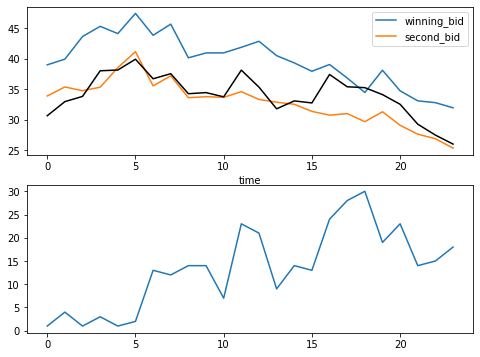

In [2]:
bid_df = house.bidder_tracker.make_dataframe(variables=['bids', 'budgets'])
auc_df = house.auction_tracker.make_dataframe()

plt.rc('figure', figsize=(8, 6))
fig, (ax1, ax2) = plt.subplots(2, 1)
time = np.linspace(0, 24, n_rounds)
hours = auc_df.time.dt.hour
auc_df[['winning_bid', 'second_bid']].groupby(hours).mean().plot(ax=ax1)
auc_df['reserve_price'].groupby(hours).mean().plot(c='k', ax=ax1)
# bid_df['budgets'].mean(axis=1).plot(ax=ax2)
ax2.plot(auc_df.time.dt.hour.unique(), auc_df.assign(cnt=np.where(auc_df.winner.isna(), 1, 0)).groupby(auc_df.time.dt.hour)['cnt'].sum())
plt.show()

In [3]:
functions = [None, Rp.gradient_based, Rp.one_shot]
params = [None, {'smoothing_rate': 100, 'learning_rate': 0.01}, None]

n_days = 10
revenues = np.zeros((n_days, len(functions)))
no_winner = np.zeros((n_days, len(functions)))

for c, fun in enumerate(functions):
    par = params[c]
    for d in range(n_days):
        auctioned_objects = np.array([AuctionedObject(i, 2.5, np.inf) for i in range(n_objects)])
        auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 20)
        bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])
        house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                        reserve_price_function=fun,
                                        reserve_price_function_params=par, 
                                        track_auctions=True, track_bidders=False
                                       )
        house.run()

        revenues[d,c] = house.auctioneer.revenue.round(2)
        no_winner[d,c] = house.auction_tracker.make_dataframe().winner.isna().sum()/n_rounds

In [4]:
revenues.mean(axis=0)
revenues

array([[29591.56, 29533.87, 29576.05],
       [29378.35, 29584.25, 29777.96],
       [29644.9 , 29347.15, 29708.8 ],
       [29685.55, 29751.88, 29913.9 ],
       [29548.64, 29065.79, 29920.35],
       [29726.84, 29570.29, 30033.71],
       [29846.22, 29801.79, 29925.87],
       [29457.07, 29843.59, 29667.11],
       [29376.07, 29835.21, 29466.8 ],
       [29357.03, 29218.48, 29906.88]])

In [5]:
no_winner

array([[0.025, 0.451, 0.072],
       [0.018, 0.469, 0.074],
       [0.012, 0.479, 0.069],
       [0.01 , 0.413, 0.065],
       [0.018, 0.511, 0.071],
       [0.023, 0.484, 0.069],
       [0.02 , 0.461, 0.067],
       [0.024, 0.434, 0.074],
       [0.018, 0.429, 0.076],
       [0.028, 0.457, 0.068]])

# Throttling 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from AuctionSimulator.Agents.Sellers import AuctionedObject, Auctioneer
from AuctionSimulator.Agents.Bidders import SimpleBidder
from AuctionSimulator.AuctionHouse import Throttling as Thr
from AuctionSimulator.AuctionHouse import AuctionHouse

n_rounds = 1000
n_objects = 100
n_bidders = 130

budgets = np.array([30., 50., 80., 100., 120., 200., 300., 500., 1000.])
budgets_p = np.ones(9) / 9
budgets_init = np.array([np.random.choice(budgets, p=budgets_p) for _ in range(n_bidders)])

fees = np.array([0, 0.3, 0.36, 0.68])
fees_p = np.array([0.36, 0.14, 0.30, 0.2])
fees_init = np.array([np.random.choice(fees, p=fees_p) for i in range(n_objects)])

auctioned_objects = np.array([AuctionedObject(i, 3, np.inf, fee=fees_init[i]) for i in range(n_objects)])
auctioneer = Auctioneer(auctioned_objects, x0=np.ones(n_objects) * 0)
bidders = np.array([SimpleBidder(budget=budgets_init[i]) for i in range(n_bidders)])

# throttling
plan = Thr.Planning(n_rounds, budgets_init).sigmoid_planning(s=0.5, t0=13)
# plan = Thr.Planning(n_rounds, budgets_init).uniform_planning()
# plan = Thr.Planning(n_rounds, budgets_init).empirical_planning()
# probability_function = Thr.Probability().linear_probability
# probability_function_params = {'floor': 0.25}
probability_function = Thr.Probability().total_probability
probability_function_params = {'prob_under_plan': 0.25}

house = AuctionHouse.Controller(n_rounds, auctioneer, bidders,
                                throttling=True, 
                                plan=plan, probability_function=probability_function,
                                probability_function_params=probability_function_params
                                )

In [6]:
%%time
house.run()

Wall time: 748 ms


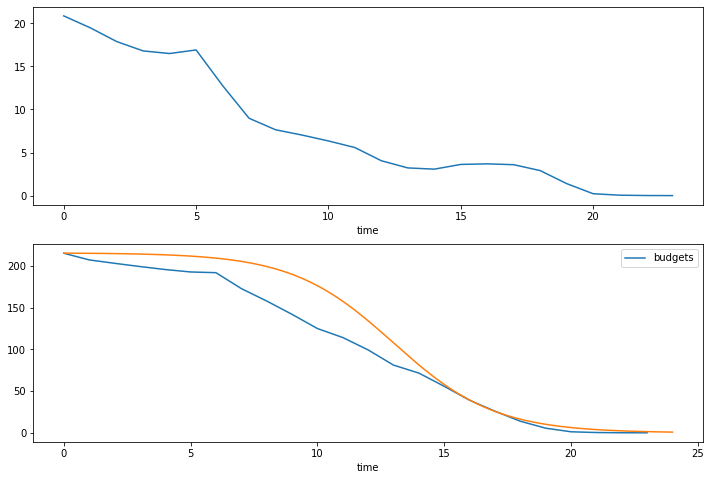

In [7]:
auc_df = house.auction_tracker.make_dataframe()
bid_df = house.bidder_tracker.make_dataframe()

plt.rc('figure', figsize=(12, 8))
fig, (ax1, ax2) = plt.subplots(2, 1)

time = auc_df['time'].dt.hour

df = bid_df['bids'].groupby(time).mean()
df.mean(axis=1).plot(ax=ax1)

df = bid_df['budgets'].groupby(time).max()
df.mean(axis=1).plot(ax=ax2, label='budgets')
ax2.plot(house.time, plan.mean(axis=1))
ax2.legend()
plt.show()

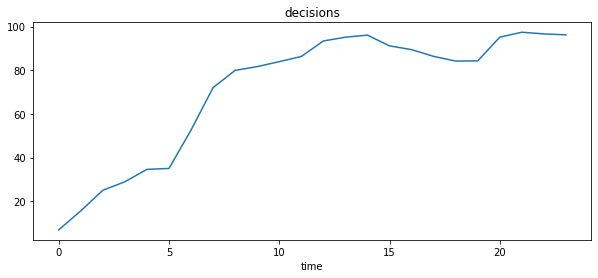

In [8]:
plt.rc('figure', figsize=(10,4))
bid_df[['decisions']].sum(axis=1).groupby(auc_df.time.dt.hour).mean().plot(title='decisions')
plt.show()